
# Face Mask Detection – Komplettes Notebook-Gerüst 
# Ein CNN-Modell, mehrfach parametrisiert
# Datensatz: kagglehub "ashishjangra27/face-mask-12k-images-dataset"





In [5]:
# 0) Setup & Imports
import os, pathlib, math, random, shutil,json

import creds
import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow:", tf.__version__)

TensorFlow: 2.12.0


In [11]:
# 1) Pfade definieren
NB_DIR = pathlib.Path.cwd()
PROJECT_ROOT = NB_DIR.parent
DATA_ROOT = PROJECT_ROOT / "data"

# 2) kaggle.json laden
kaggle_settings_path = NB_DIR / "kaggle.json"
if not kaggle_settings_path.exists():
    raise FileNotFoundError(f"kaggle.json nicht gefunden: {kaggle_settings_path}")

with open(kaggle_settings_path, "r") as f:
    creds = json.load(f)

os.environ["KAGGLE_USERNAME"] = creds["username"]
os.environ["KAGGLE_KEY"] = creds["key"]

# 3) Download nur, wenn Train-Ordner fehlt
if not (DATA_ROOT / "Train").exists():
    DATA_ROOT.mkdir(parents=True, exist_ok=True)
    print("Starte Download des Face-Mask-Datasets mit KaggleHub …")

    # ↪️ Liefert den entpackten Dataset-Ordner im lokalen Cache!
    dataset_root = pathlib.Path(
        kagglehub.dataset_download("ashishjangra27/face-mask-12k-images-dataset")
    )

    # In diesem Ordner liegt bereits „Face Mask Dataset/Train …“
    SRC = dataset_root / "Face Mask Dataset"

    import shutil

    for split in ["Train", "Validation", "Test"]:
        dst = DATA_ROOT / split
        if dst.exists():
            shutil.rmtree(dst)
        shutil.copytree(SRC / split, dst)

    print("Download abgeschlossen. Ordner Train/Validation/Test erstellt.")
else:
    print("Train/Validation/Test existieren bereits – Download übersprungen.")

print("Dataset liegt unter:", DATA_ROOT)


Train/Validation/Test existieren bereits – Download übersprungen.
Dataset liegt unter: /Users/mohamedbondok/Desktop/Uni/MSC FH Campus/Semester 2/AI Engineering/Project/Face-Mask-Detection-/data


In [18]:
# 2) Verzeichnisse setzen – Struktur: Train / Validation / Test
IMG_SIZE   = (128, 128)
BATCH_SIZE = 32
SEED       = 42

train_dir = DATA_ROOT / "Train"
val_dir   = DATA_ROOT / "Validation"
test_dir  = DATA_ROOT / "Test"


In [19]:
# 3) Daten laden
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print("Klassen:", class_names)

Found 10000 files belonging to 2 classes.


2025-06-04 19:10:06.590606: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-06-04 19:10:06.591888: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-04 19:10:06.594956: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-06-04 19:10:06.596695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-04 19:10:06.597502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
Klassen: ['WithMask', 'WithoutMask']


2025-06-04 19:10:55.793845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_4}}]]
2025-06-04 19:10:55.794534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_4}}]]


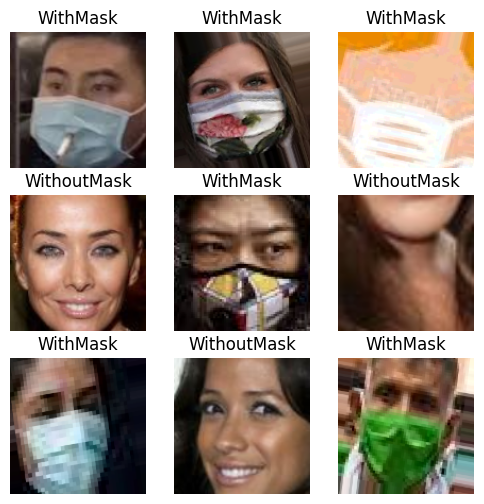

In [20]:
# 3.1) Beispielbilder anzeigen
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [21]:
# 4) Daten-Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [23]:
# 5) Modell-Fabrik
def build_cnn(conv_blocks=2, dense_units=64, learning_rate=1e-3):
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    for i in range(conv_blocks):
        x = layers.Conv2D(32 * (i + 1), 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    outputs = layers.Dense(len(class_names), activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [24]:
# 6) Hyperparameter-Varianten
VARIANTS = {
    "A_small":  {"conv_blocks": 2, "dense_units": 64,  "learning_rate": 1e-3, "epochs": 8},
    "B_medium": {"conv_blocks": 3, "dense_units": 128, "learning_rate": 5e-4, "epochs": 12},
    "C_large":  {"conv_blocks": 4, "dense_units": 128, "learning_rate": 1e-4, "epochs": 15},
}

histories, models = {}, {}

In [ ]:
# 7) Training-Schleife
for name, p in VARIANTS.items():
    print(f"\n=== Trainiere Variante {name} ===")
    model = build_cnn(p["conv_blocks"], p["dense_units"], p["learning_rate"])
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=p["epochs"],
        verbose=2,
    )
    histories[name] = history
    models[name] = model



=== Trainiere Variante A_small ===
Epoch 1/8


2025-06-04 19:11:23.779793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_4}}]]
2025-06-04 19:11:23.779990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_4}}]]
2025-06-04 19:11:24.252578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-04 19:11:24.314512: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain termin

313/313 - 21s - loss: 1.8038 - accuracy: 0.8046 - val_loss: 0.1717 - val_accuracy: 0.9325 - 21s/epoch - 66ms/step
Epoch 2/8


2025-06-04 19:11:44.441377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:11:44.549640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:11:44.600975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:11:44.652201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:11:44.703722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:11:44.752756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

313/313 - 18s - loss: 0.2263 - accuracy: 0.9208 - val_loss: 0.2410 - val_accuracy: 0.9013 - 18s/epoch - 57ms/step
Epoch 3/8


2025-06-04 19:12:02.169631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:02.280093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:02.330697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:02.378624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:02.430494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:02.476489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

313/313 - 17s - loss: 0.1675 - accuracy: 0.9380 - val_loss: 0.0966 - val_accuracy: 0.9613 - 17s/epoch - 53ms/step
Epoch 4/8


2025-06-04 19:12:18.707016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:18.847749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:18.899100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:18.949006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:19.002387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:19.048908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

313/313 - 17s - loss: 0.1705 - accuracy: 0.9400 - val_loss: 0.0975 - val_accuracy: 0.9663 - 17s/epoch - 54ms/step
Epoch 5/8


2025-06-04 19:12:35.524024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:35.663734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:35.718033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:35.777984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:35.830467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:35.886746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

313/313 - 18s - loss: 0.1271 - accuracy: 0.9550 - val_loss: 0.0940 - val_accuracy: 0.9625 - 18s/epoch - 57ms/step
Epoch 6/8


2025-06-04 19:12:53.349612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:53.518037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:53.589771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:53.643681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:53.700362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:12:53.757654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

313/313 - 37s - loss: 0.1263 - accuracy: 0.9575 - val_loss: 0.0996 - val_accuracy: 0.9700 - 37s/epoch - 118ms/step
Epoch 7/8


2025-06-04 19:13:30.319723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:13:30.628055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:13:30.726464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:13:30.839242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:13:30.952516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:13:31.062952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

313/313 - 44s - loss: 0.1140 - accuracy: 0.9618 - val_loss: 0.0748 - val_accuracy: 0.9712 - 44s/epoch - 140ms/step
Epoch 8/8


2025-06-04 19:14:14.055794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:14:14.304306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:14:14.392699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:14:14.472476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:14:14.550926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-06-04 19:14:14.632755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

313/313 - 26s - loss: 0.1330 - accuracy: 0.9561 - val_loss: 0.3269 - val_accuracy: 0.8512 - 26s/epoch - 83ms/step

=== Trainiere Variante B_medium ===
Epoch 1/12


In [ ]:
# 8) Beste Variante ermitteln
best_name = max(histories, key=lambda n: max(histories[n].history["val_accuracy"]))
best_model = models[best_name]
print("\nBeste Variante:", best_name)

In [ ]:
# 9) Evaluation
def evaluate(model, dataset):
    y_true, y_pred = [], []
    for imgs, labels in dataset:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.argmax(preds, axis=1).numpy())
    print(classification_report(y_true, y_pred, target_names=class_names))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

evaluate(best_model, test_ds)

In [ ]:
    # 10) Trainings­kurven Plot
plt.figure(figsize=(8, 5))
for name, hist in histories.items():
    plt.plot(hist.history["val_accuracy"], label=f"{name} val_acc")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend(); plt.show()